In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from scipy.stats import ranksums

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

In [6]:
from scipy.stats import false_discovery_control

In [7]:
import random
import seaborn as sns

In [8]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

In [82]:
from scipy.stats import norm

# Chromosome-wide fold-changes

In [9]:
df = pd.read_csv("./input/counts_df.csv", index_col=0)
# counts matrix derived from Seurat object (in R):
# obj = readRDS("seurat_obj_GEx_filtered_SP_shuffleBC_revision_Lane2_raw_20240906.RDS")
# df = data.frame(obj$RNA$counts)
# write.csv(df, "counts_df.csv")

In [10]:
adata = sc.AnnData(df.T)

In [11]:
adata.obs.index = ["-".join(i.split(".")) for i in adata.obs.index]

In [12]:
print(adata.shape)
sc.pp.filter_genes(adata, min_cells = 10)
print(adata.shape)

(20800, 21630)
(20800, 18099)


In [13]:
sc.pp.normalize_total(adata)

In [14]:
rearr = pd.read_csv("./input/20240914_Lane2__1UMI_rearrangements.tsv", sep="\t", index_col=0)

In [15]:
rearr['key'] = rearr['rearranged_real_barcode1']+","+rearr['rearranged_real_barcode2']

In [16]:
del_cells = []
with open("./input/deletion_cells.txt", "r+") as f:
    del_cells = f.read().splitlines()

In [17]:
parent_cells = []
with open("./input/parental_cells.txt", "r+") as f:
    parent_cells = f.read().splitlines()

In [18]:
len(del_cells)

465

In [19]:
len(parent_cells)

680

In [20]:
all_cells = del_cells+parent_cells

In [21]:
len(del_cells)+len(parent_cells)

1145

In [22]:
len(set(all_cells))

1145

In [23]:
adata_test = adata[all_cells,:].copy()

In [24]:
adata_test.obs['chr15_del'] = "No"

In [25]:
adata_test.obs.loc[del_cells, 'chr15_del'] = "Yes"

In [26]:
gff3 = "./input/gencode.v38.basic.annotation.gff3"
# downloaded from https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.basic.annotation.gff3.gz

In [27]:
gencode = pd.read_table(gff3, comment="#", sep = "\t", names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])
gencode.head() 
gencode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873108 entries, 0 to 1873107
Data columns (total 9 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   seqname    object
 1   source     object
 2   feature    object
 3   start      int64 
 4   end        int64 
 5   score      object
 6   strand     object
 7   frame      object
 8   attribute  object
dtypes: int64(2), object(7)
memory usage: 128.6+ MB


In [28]:
gencode_genes = gencode[(gencode.feature == "gene")][['seqname', 'start', 'end', 'attribute']].copy().reset_index().drop('index', axis=1)

In [29]:
gencode_genes['gene_name'] = [i.split("gene_name=")[1].split(";")[0] for i in gencode_genes['attribute'].values]

In [30]:
chr15 = gencode_genes[gencode_genes['seqname']=="chr15"]

In [31]:
start = 50426416
end = 50873610

In [32]:
start_left = 0 #start-10000000
end_right = max(chr15['end'])+1000 #end+10000000

In [33]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        #print(3)

In [34]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [35]:
gen = [i for i in del_genes if i in adata.var.index]

In [36]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [37]:
gen_df.set_index("gene_name", inplace=True)

In [38]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
LINC01193,chr15,20940380,21058440,ID=ENSG00000258710.8;gene_id=ENSG00000258710.8...
AC138649.1,chr15,22714939,22715225,ID=ENSG00000277867.1;gene_id=ENSG00000277867.1...
NIPA1,chr15,22773063,22829789,ID=ENSG00000170113.16;gene_id=ENSG00000170113....
NIPA2,chr15,22838644,22869362,ID=ENSG00000140157.16;gene_id=ENSG00000140157....
CYFIP1,chr15,22867052,22981063,ID=ENSG00000273749.5;gene_id=ENSG00000273749.5...
...,...,...,...,...
SNRPA1,chr15,101281510,101295282,ID=ENSG00000131876.17;gene_id=ENSG00000131876....
PCSK6,chr15,101289784,101525202,ID=ENSG00000140479.18;gene_id=ENSG00000140479....
PCSK6-AS1,chr15,101334437,101337428,ID=ENSG00000259764.1;gene_id=ENSG00000259764.1...


In [39]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [40]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

In [41]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
LINC01193,NaN,0.5,20940380,21058440,0.0,0.0
AC138649.1,1.031053,0.5675534576016079,22714939,22715225,0.062366,0.055882
NIPA1,0.96264,0.5502497220332335,22773063,22829789,0.150538,0.144118
NIPA2,0.828058,0.1529207892110272,22838644,22869362,0.301075,0.327941
CYFIP1,0.861841,0.3170183822480743,22867052,22981063,0.217204,0.229412
...,...,...,...,...,...,...
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235
PCSK6,1.172984,0.6402179215367612,101289784,101525202,0.068817,0.055882
PCSK6-AS1,4.839606,0.5078401296553244,101334437,101337428,0.002151,0.001471
TM2D3,1.391897,0.9044334470459958,101621444,101652391,0.191398,0.15


In [42]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [43]:
info_df['p-bh'] = false_discovery_control(info_df['p-value'].values.astype(float))
info_df['p-bonferroni'] = info_df['p-value']*info_df.shape[0]

In [44]:
info_df[info_df['p-value']<=0.05]

,Fold-change,p-value,start,end,%_group,%_rest,p-bh,p-bonferroni
EID1,0.847768,0.0001815306426335597,48878134,48880173,0.804301,0.829412,0.041752,0.041752
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412,0.605594,3.027972
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412,0.053196,0.106392
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588,0.297980,1.191921
ARPP19,0.82684,0.04083578811215718,52547045,52569883,0.391398,0.438235,0.998202,9.392231
RCCD1,0.655439,0.0020081400533134524,90954870,90963125,0.187097,0.285294,0.153957,0.461872
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235,0.807494,4.844967


In [45]:
start,end

(50426416, 50873610)

In [46]:
info_df.to_csv("./output/gene_pvalues_chr15.csv", index=True)

In [47]:
info_df['center'] = (info_df['start']+info_df['end'])/2

In [48]:
moving_avg = np.convolve(info_df['Fold-change'], np.ones(3)/3, mode='valid')

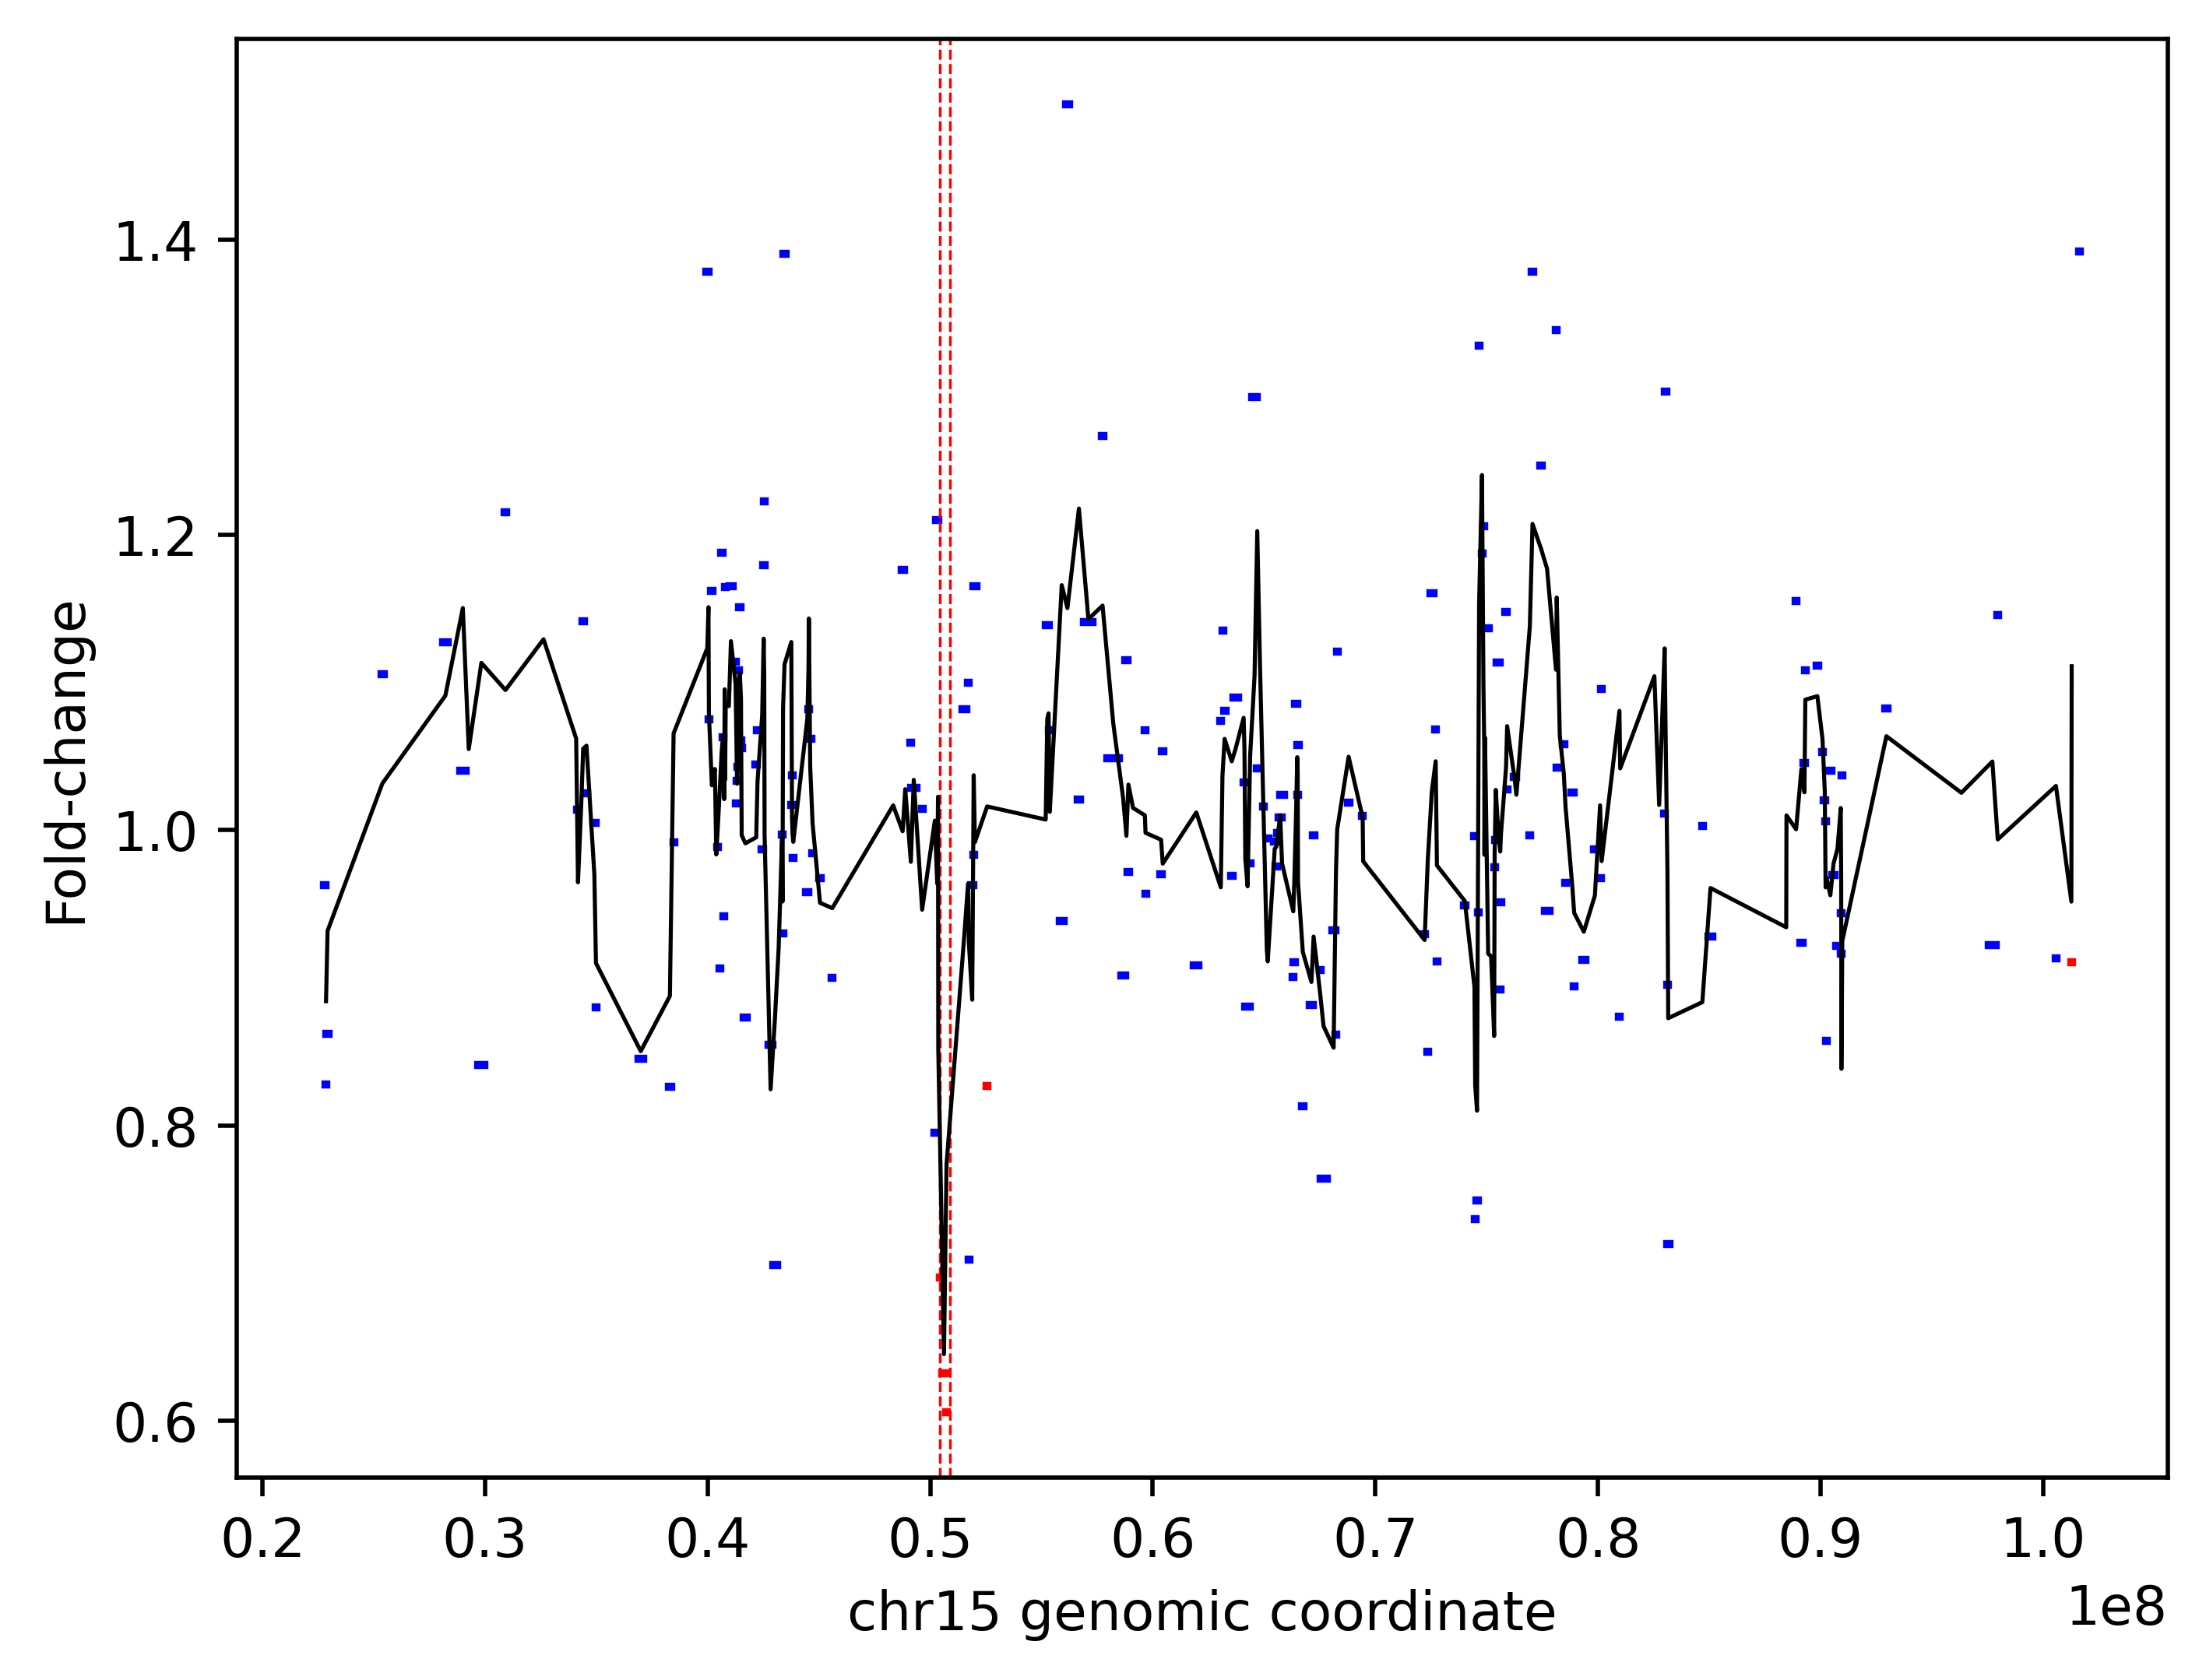

In [49]:
for i in info_df.index:
    plt.plot([info_df.loc[i,"start"],info_df.loc[i,"end"]],
              [info_df.loc[i,"Fold-change"],info_df.loc[i,"Fold-change"]], 
             color="blue" if float(info_df.loc[i,"p-value"]) > 0.05 else "red")#, 
             #alpha=1-float(info_df.loc[i,"p-value"]))#, cmap="Reds")
plt.axvline(x=start, linestyle="--", linewidth=0.5, color="red")
plt.axvline(x=end, linestyle="--", linewidth=0.5, color="red")
plt.xlabel("chr15 genomic coordinate")
plt.ylabel("Fold-change")

plt.plot(info_df.iloc[1:-1,:]['center'], moving_avg, color="black", linewidth=0.75)
plt.savefig("./output/chr15_total.pdf", dpi=500)
plt.show()

# Downsampling cell number

In [50]:
start = 50426416
end = 50873610

In [51]:
start_left = start#-10000000
end_right = end#+10000000

In [52]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        #print(3)

In [53]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [54]:
gen = [i for i in del_genes if i in adata.var.index]

In [55]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [56]:
gen_df.set_index("gene_name", inplace=True)

In [57]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
USP8,chr15,50424380,50514421,ID=ENSG00000138592.14;gene_id=ENSG00000138592....
TRPM7,chr15,50552473,50686797,ID=ENSG00000092439.16;gene_id=ENSG00000092439....
SPPL2A,chr15,50702266,50765709,ID=ENSG00000138600.10;gene_id=ENSG00000138600....


In [58]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [59]:
from scipy.stats import ranksums

In [60]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

In [61]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [62]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588


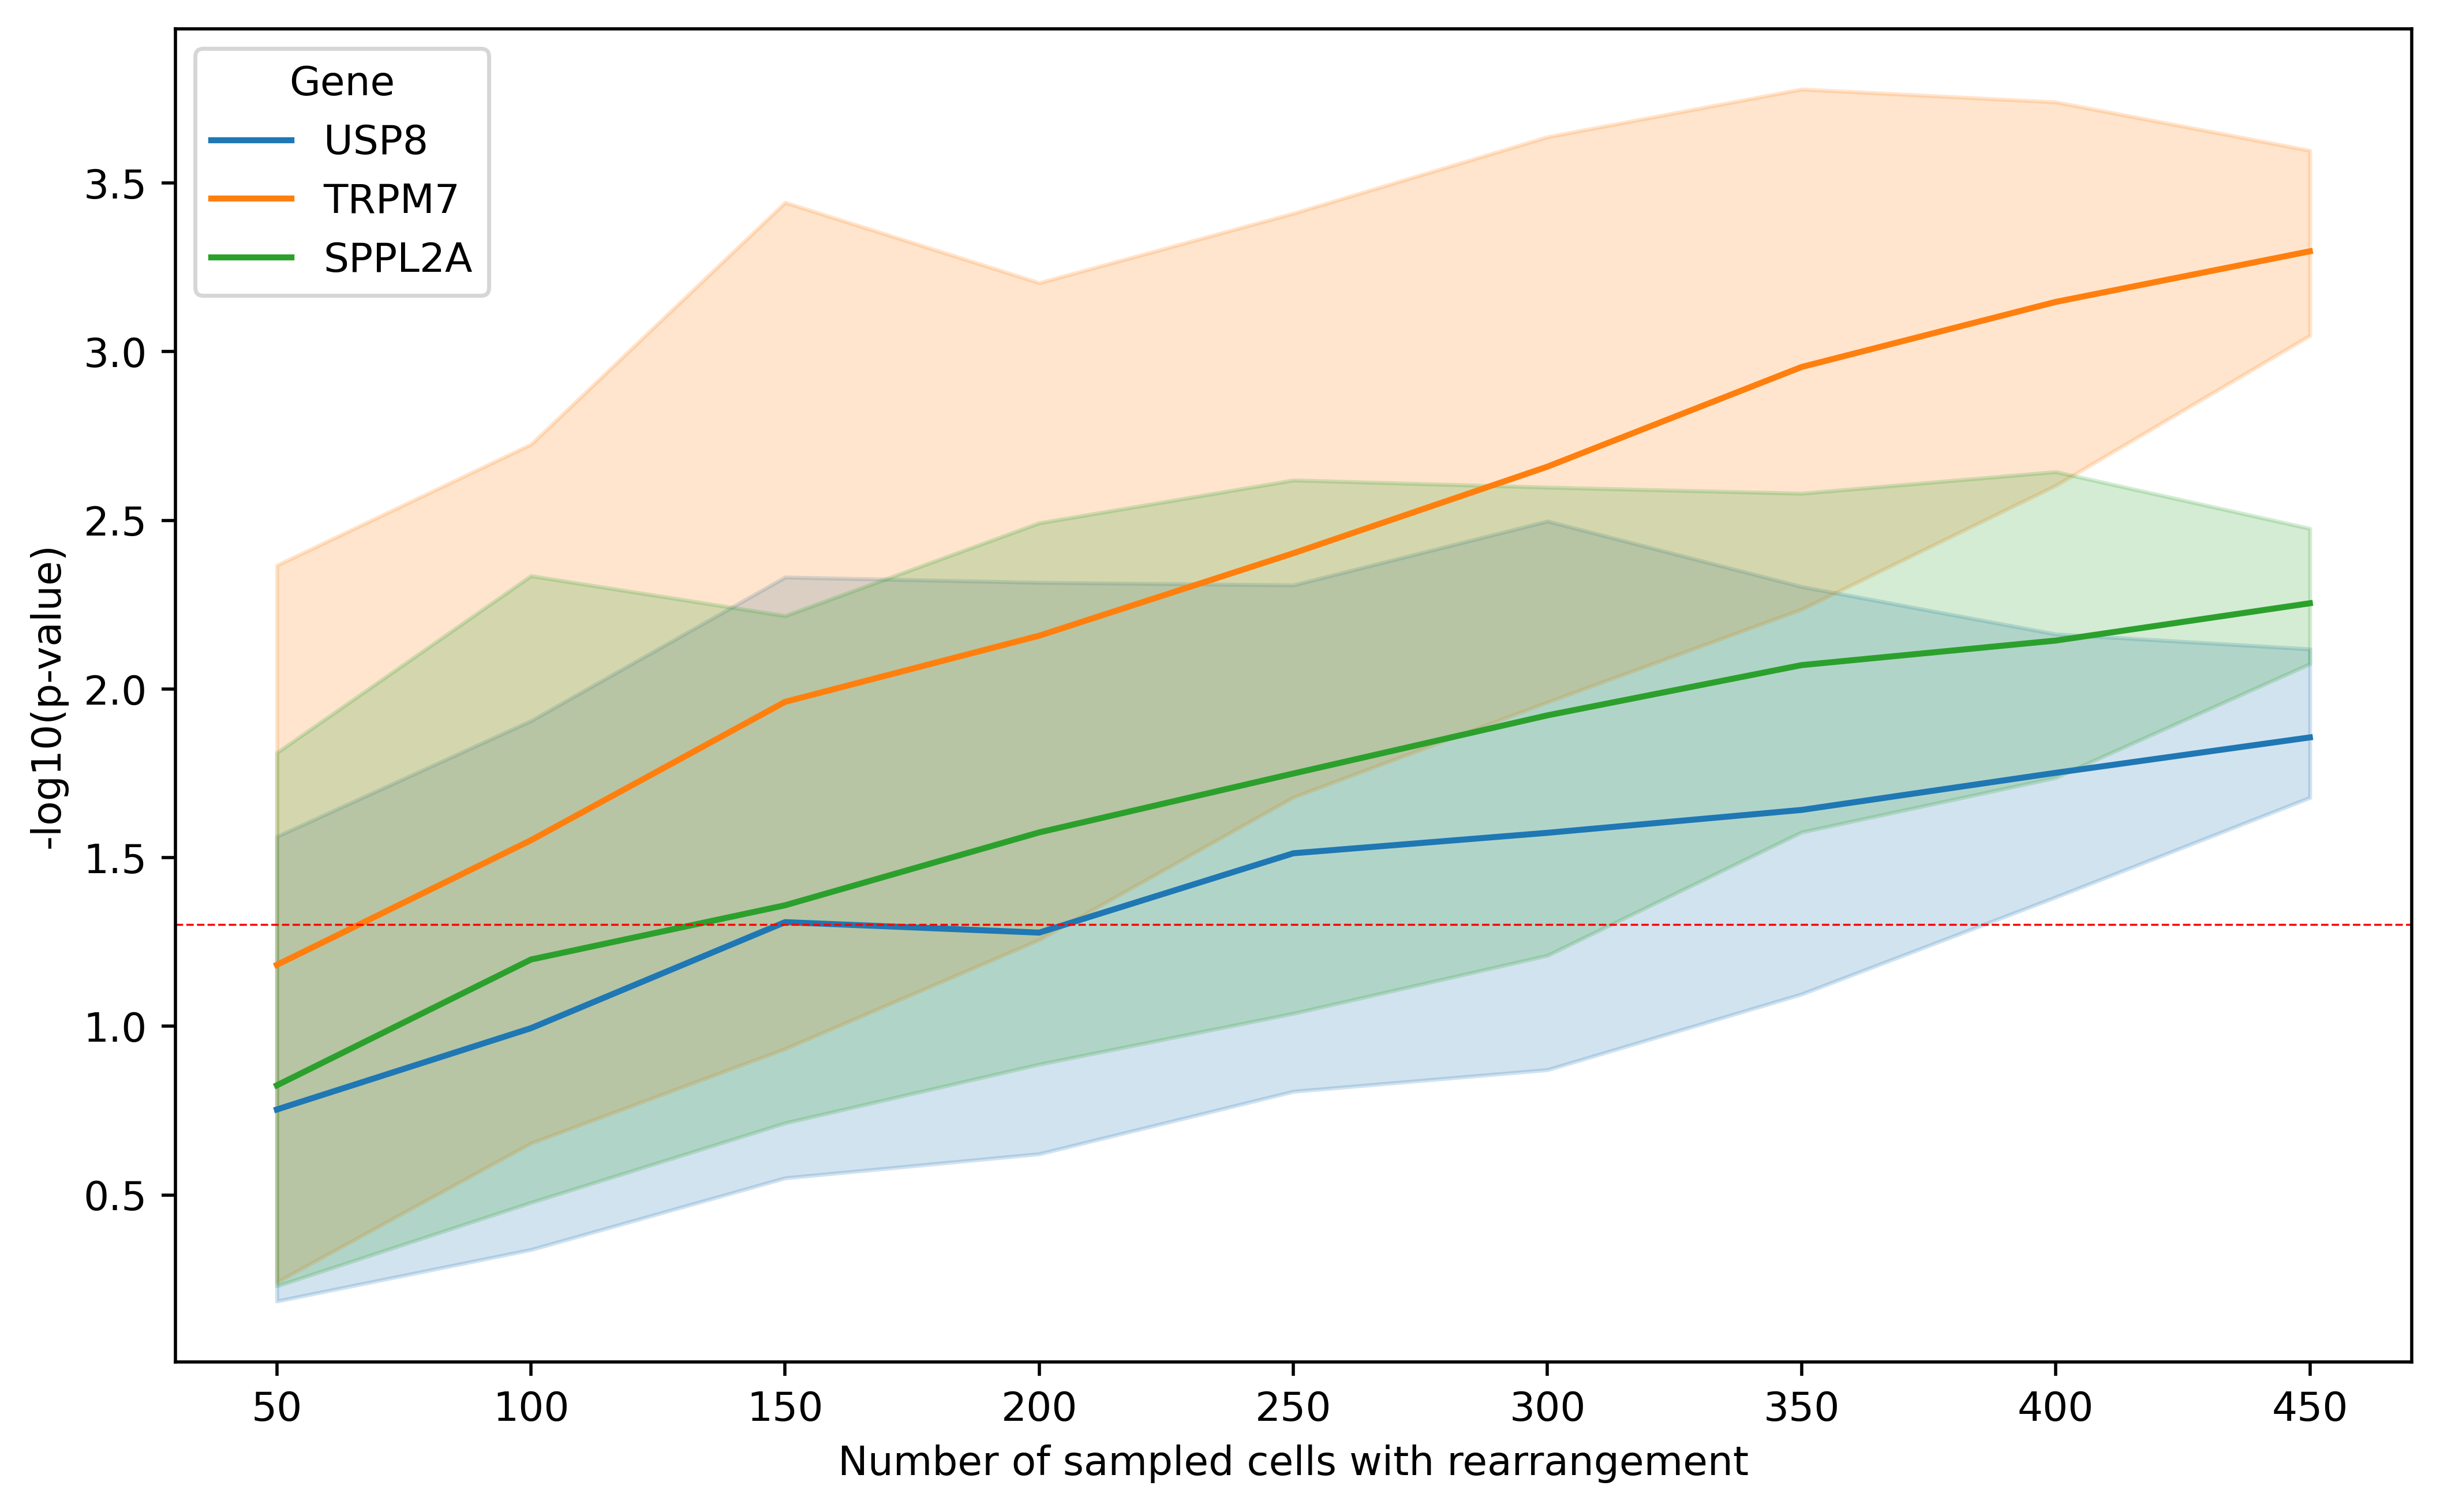

In [63]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = ranksums(adata_test[group, gene].X, adata_test[rest, gene].X, alternative='less')[1]
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'p_value': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='neg_log10_p', hue='gene', errorbar=('pi', 95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("-log10(p-value)")
plt.axhline(y=-np.log10(0.05), linestyle="--", linewidth=0.5, color="red")
#plt.title("P-value evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("./output/downsampling_pvalue.pdf", dpi=500)
plt.show()

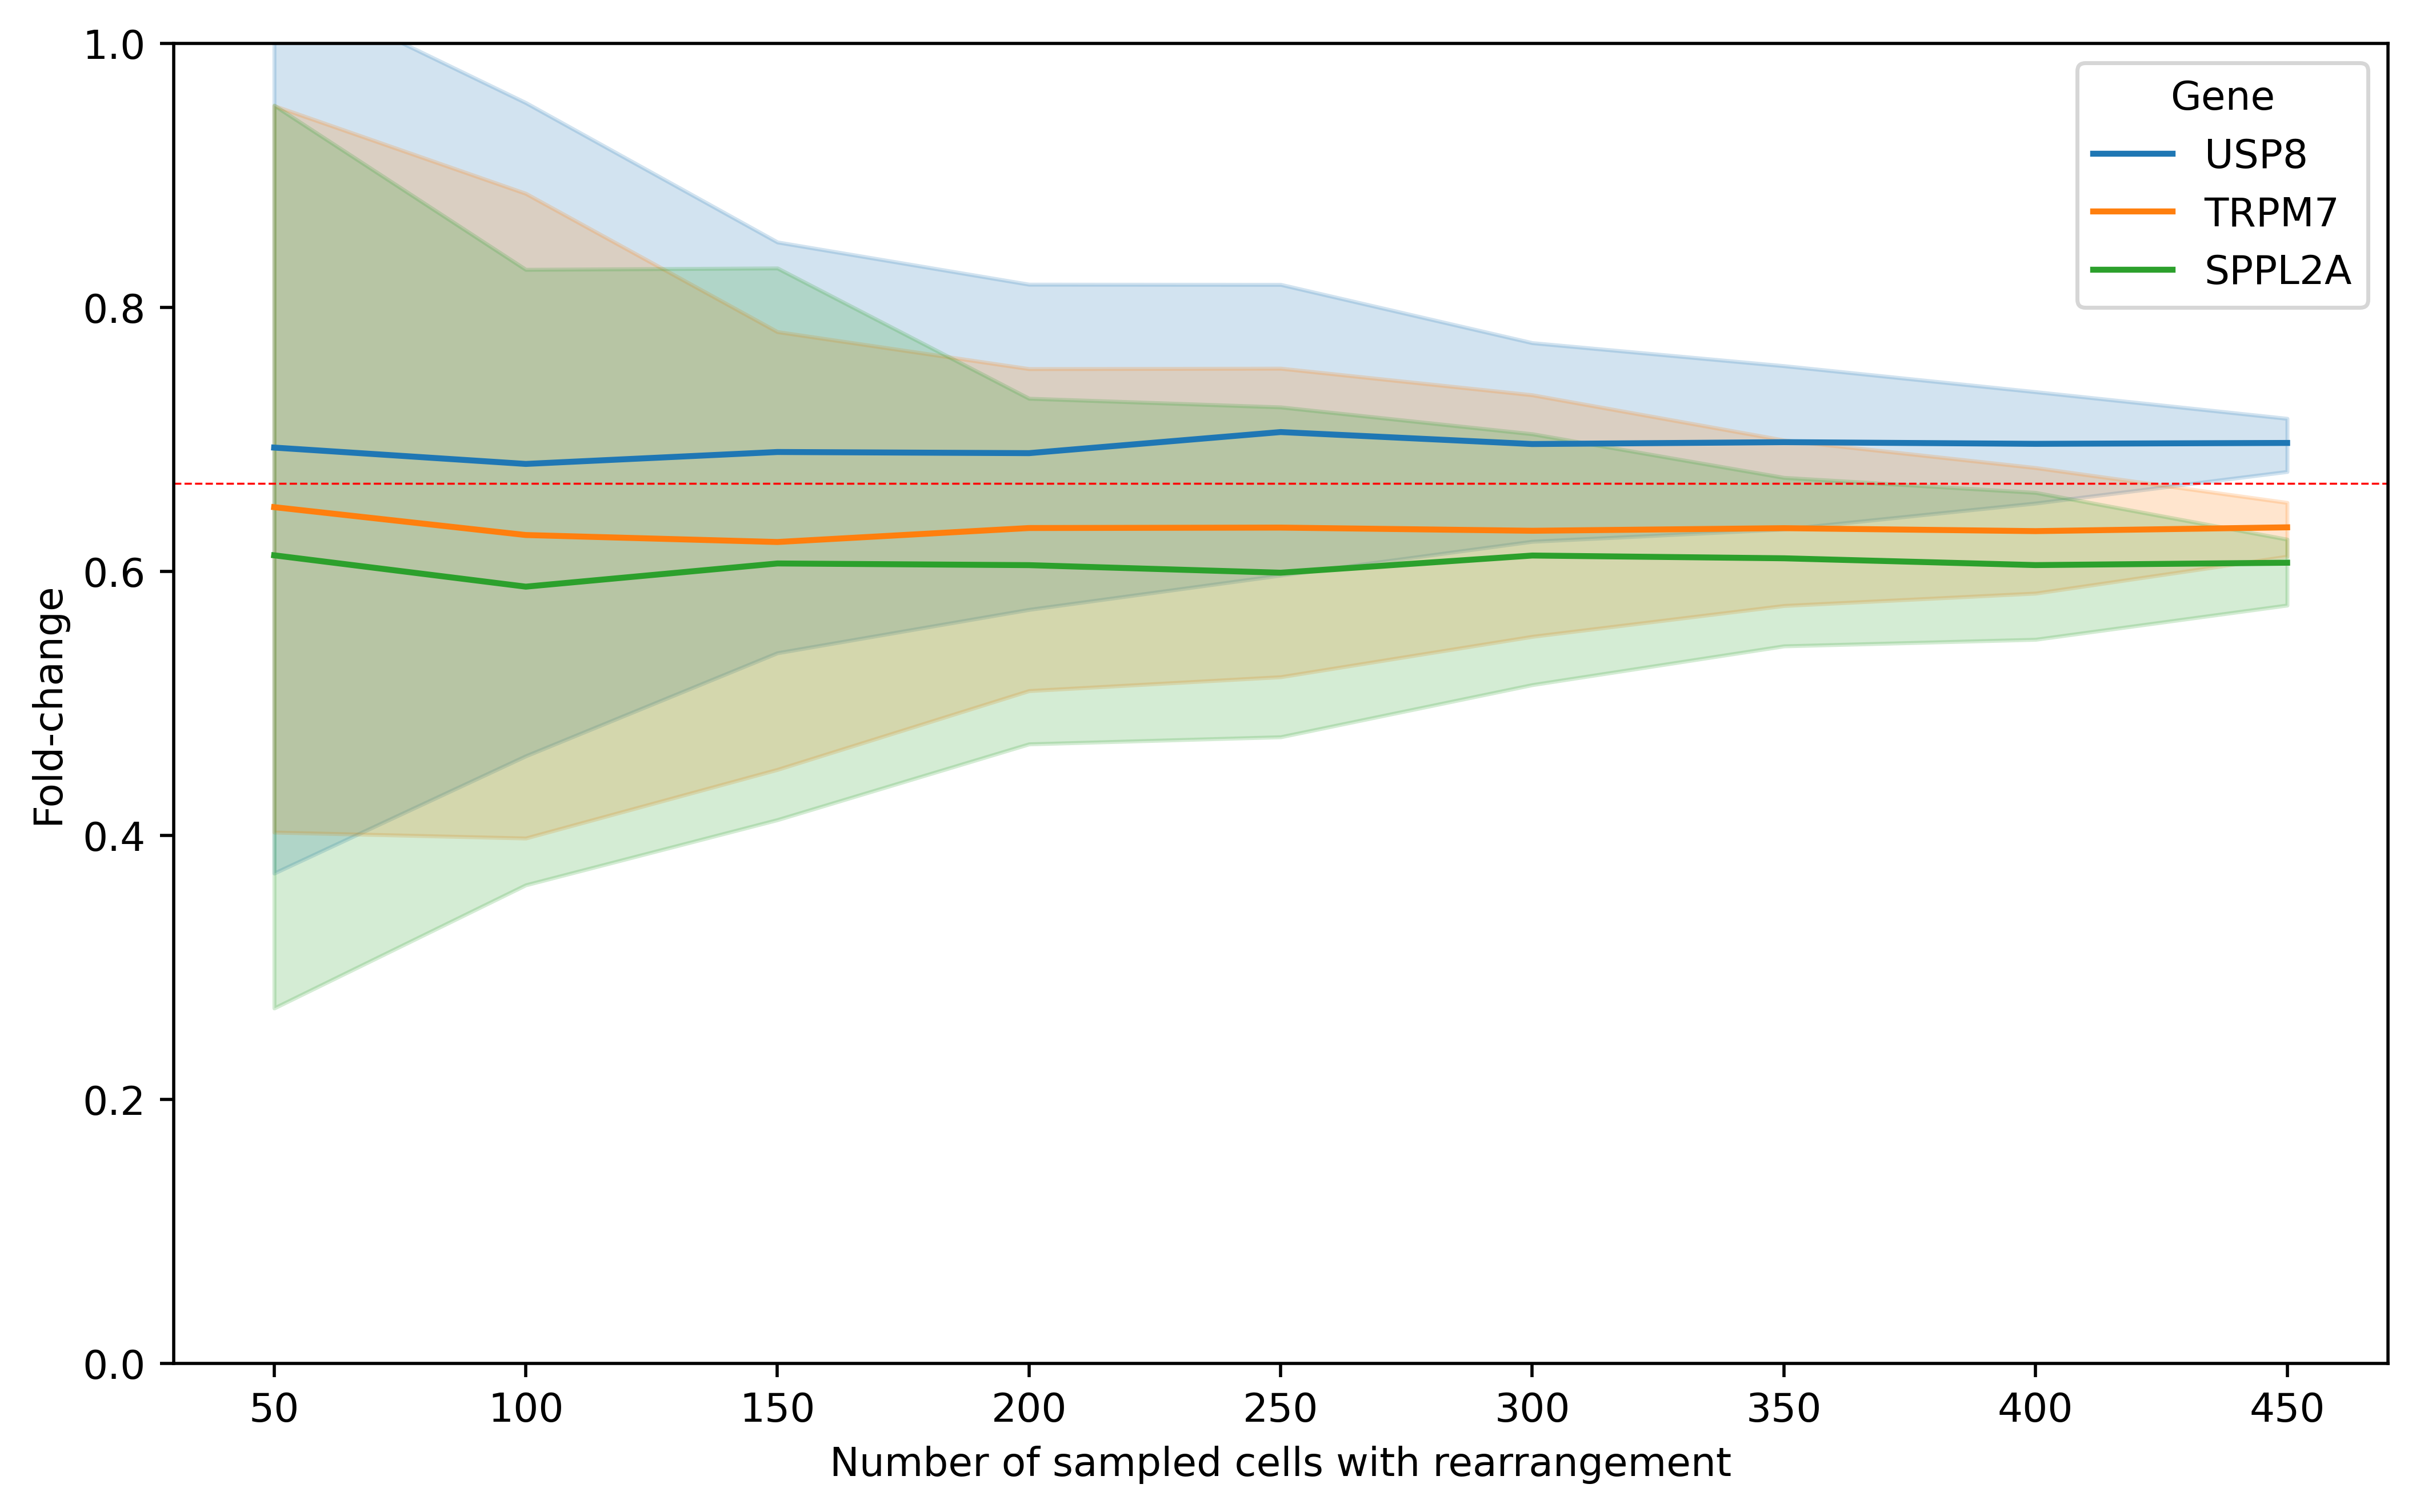

In [64]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = np.mean(adata_test[group,gene].X)/np.mean(adata_test[rest,gene].X)
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'Fold-change': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='Fold-change', hue='gene', errorbar=('pi',95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("Fold-change")
plt.ylim([0,1])
plt.axhline(y=(2.0/3.0), linestyle="--", linewidth=0.5, color="red")
#plt.title("Fold- evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("./output/downsampling_foldchange.pdf", dpi=500)
plt.show()

# Q-Q plot

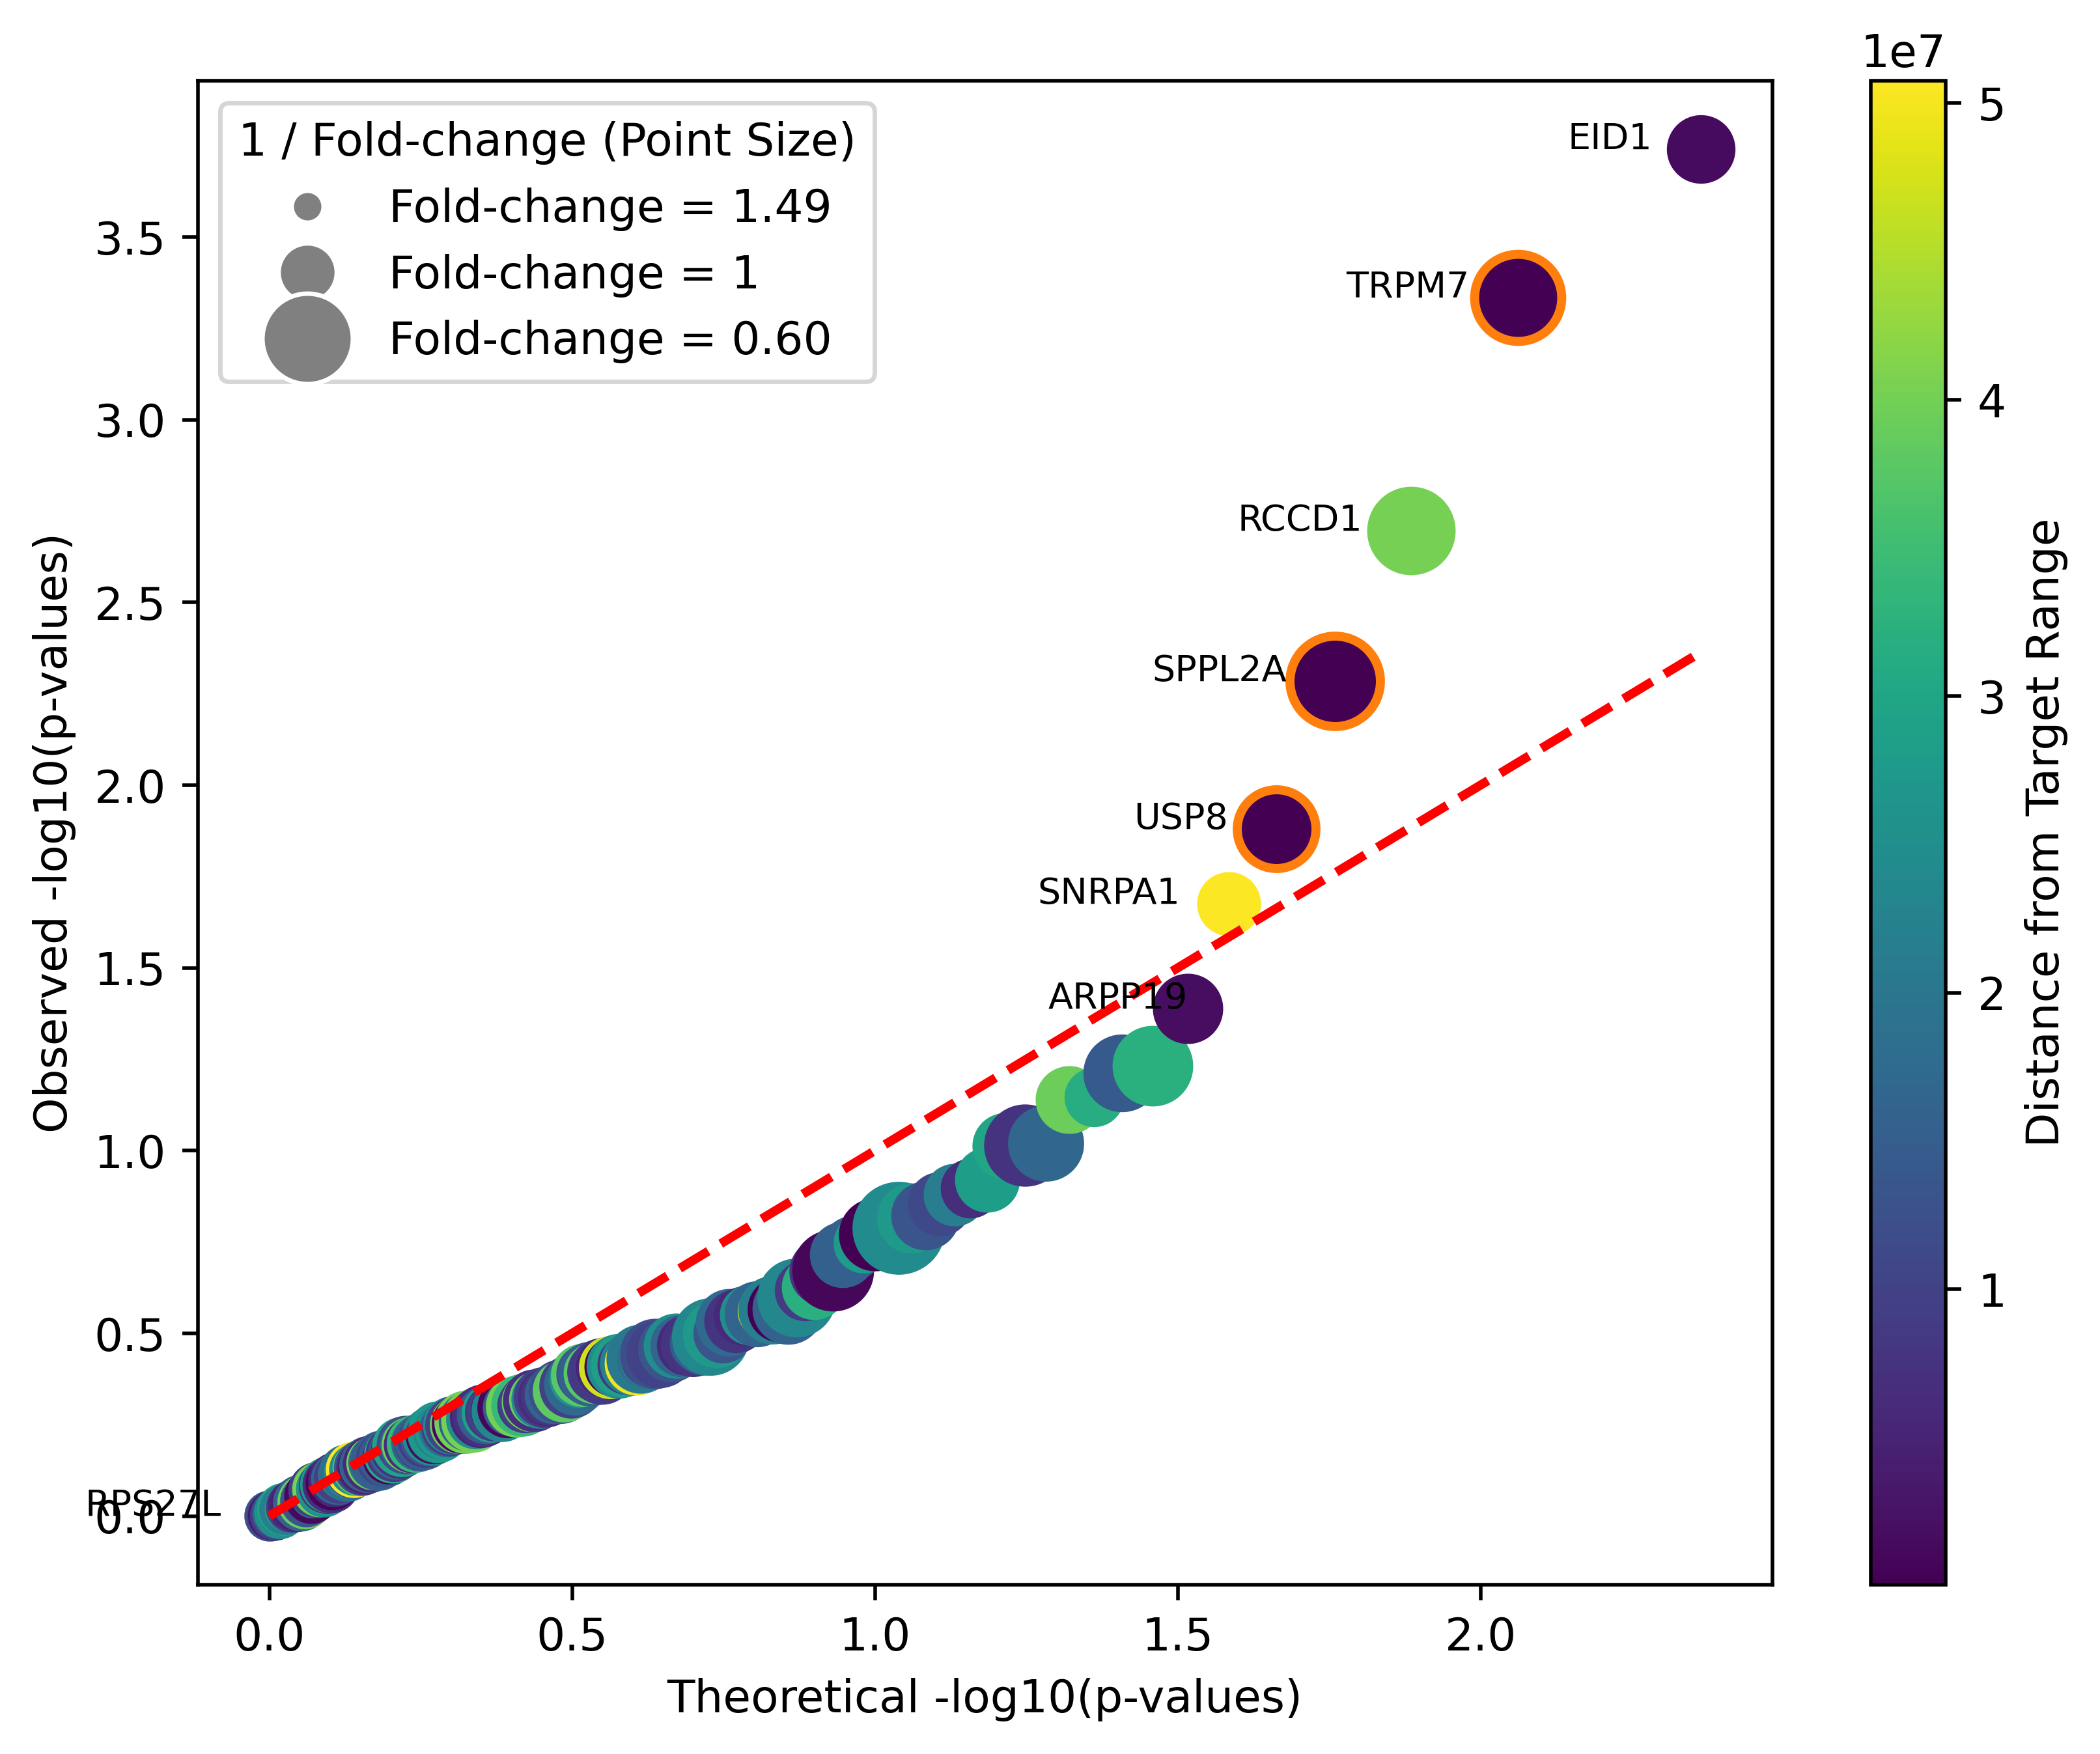

In [66]:
df_chr15 = pd.read_csv('./output/gene_pvalues_chr15.csv')

df_chr15 = df_chr15.rename(columns={'Unnamed: 0': 'gene'})

df_chr15['-log10(p-value)'] = -np.log10(df_chr15['p-value'])

# Define the target chromosomal range
target_range_start = 50426416  # Start of the range
target_range_end = 50873610    # End of the range

# Step 1: Compute -log10 of p-values
df_chr15['-log10(p-value)'] = -np.log10(df_chr15['p-value'])

# Step 2: Compute the midpoint of each gene
df_chr15['midpoint'] = (df_chr15['start'] + df_chr15['end']) / 2

# Step 3: Calculate the shortest distance from the target range
df_chr15['distance_from_target'] = np.minimum(
    abs(df_chr15['midpoint'] - target_range_start), 
    abs(df_chr15['midpoint'] - target_range_end)
)

# Step 4: Identify genes that overlap with the target range
df_chr15['overlap'] = (df_chr15['start'] <= target_range_end) & (df_chr15['end'] >= target_range_start)

# Step 5: Sort the observed -log10(p-values) and gene names together
sorted_indices = np.argsort(df_chr15['-log10(p-value)'])  # Indices to sort observed values
observed = df_chr15['-log10(p-value)'].iloc[sorted_indices].values

# Min and max fold-change based on actual data distribution
min_fc = 0.6
max_fc = 1.49

# Scale the sizes based on 1 / fold-change
scaled_sizes = ((1 / df_chr15['Fold-change']) * 25).iloc[sorted_indices].values
sizes = np.interp(scaled_sizes**2, [16**2, 41**2], [50, 400])

sorted_genes = df_chr15['gene'].iloc[sorted_indices].values
sorted_distances = df_chr15['distance_from_target'].iloc[sorted_indices].values
sorted_overlap = df_chr15['overlap'].iloc[sorted_indices].values

# Step 6: Generate the theoretical quantiles from a uniform distribution, sorted in ascending order
n = len(observed)
theoretical = -np.log10(np.linspace(1/(n+1), 1, n))
theoretical = np.sort(theoretical)

# Step 7: Scale the distance for the color mapping
norm = plt.Normalize(sorted_distances.min(), sorted_distances.max())
colors = cm.viridis(norm(sorted_distances))

# Step 8: Create the Q-Q plot
fig, ax = plt.subplots(figsize=(7.8, 6))

# Scatter plot with point size and color based on distance
for i in range(len(observed)):
    if sorted_overlap[i]:
        # Make overlapping genes prominent with red edges
        ax.scatter(theoretical[i], observed[i], color=colors[i], edgecolor='#ff7f0e',linewidths=2, s=sizes[i], label=sorted_genes[i] if i == 0 else "")
    else:
        # Non-overlapping genes
        ax.scatter(theoretical[i], observed[i], color=colors[i], s=sizes[i])

# Step 9: Label points above the diagonal with gene names
for i in range(len(observed)):
    if observed[i] > theoretical[i]:  # Check if the point is above the diagonal
        ax.text(theoretical[i]-0.08, observed[i], sorted_genes[i], fontsize=8, ha='right')
    elif sorted_genes[i] == 'ARPP19':
        ax.text(theoretical[i], observed[i], sorted_genes[i], fontsize=8, ha='right')

# Add the diagonal reference line
ax.plot([theoretical.min(), theoretical.max()], [theoretical.min(), theoretical.max()], color='red', linestyle='--', lw=2)

# Add color bar to represent distance
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, label='Distance from Target Range')

# Step 10: Add a custom legend for the sizes based on 1 / Fold-change
# We use actual min and max fold-change values to create the legend
# The legend marker sizes are adjusted using the same size scaling as the plot
legend_sizes = np.interp([1/max_fc, 1, 1/min_fc], [1/max_fc, 1/min_fc], [50, 400])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Fold-change = {max_fc:.2f}', markerfacecolor='grey', markersize=np.sqrt(legend_sizes[0])),
    Line2D([0], [0], marker='o', color='w', label=f'Fold-change = 1', markerfacecolor='grey', markersize=np.sqrt(legend_sizes[1])),
    Line2D([0], [0], marker='o', color='w', label=f'Fold-change = {min_fc:.2f}', markerfacecolor='grey', markersize=np.sqrt(legend_sizes[2])),
]

# Add the size legend to the plot
ax.legend(handles=legend_elements, title="1 / Fold-change (Point Size)", loc='upper left')

# Customize plot labels and title
ax.set_xlabel("Theoretical -log10(p-values)")
ax.set_ylabel("Observed -log10(p-values)")
plt.savefig("./output/qq_plot.png", dpi=500)

# Fold-change histogram

In [68]:
gencode_genes.set_index("gene_name", inplace=True)

In [69]:
gencode_genes

,seqname,start,end,attribute
gene_name,,,,
DDX11L1,chr1,11869,14409,ID=ENSG00000223972.5;gene_id=ENSG00000223972.5...
WASH7P,chr1,14404,29570,ID=ENSG00000227232.5;gene_id=ENSG00000227232.5...
MIR6859-1,chr1,17369,17436,ID=ENSG00000278267.1;gene_id=ENSG00000278267.1...
MIR1302-2HG,chr1,29554,31109,ID=ENSG00000243485.5;gene_id=ENSG00000243485.5...
MIR1302-2,chr1,30366,30503,ID=ENSG00000284332.1;gene_id=ENSG00000284332.1...
...,...,...,...,...
MT-ND6,chrM,14149,14673,ID=ENSG00000198695.2;gene_id=ENSG00000198695.2...
MT-TE,chrM,14674,14742,ID=ENSG00000210194.1;gene_id=ENSG00000210194.1...
MT-CYB,chrM,14747,15887,ID=ENSG00000198727.2;gene_id=ENSG00000198727.2...


In [70]:
all_genes = list(set(adata_test.var.index).intersection(gencode_genes.index))

In [71]:
info_df = pd.DataFrame(index=all_genes, columns=['Fold-change', 'p-value','%_group', '%_rest','chromosome','start','end'])

In [72]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    #print(i)
    try:
        info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
        info_df.loc[i,"start"] = gencode_genes.loc[i,"start"]
        info_df.loc[i,"end"] = gencode_genes.loc[i,"end"]
        info_df.loc[i,"chromosome"] = gencode_genes.loc[i,"seqname"]
        info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
        info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
        info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)
    except:
        pass

In [73]:
info_df.shape

(14758, 7)

In [74]:
info_df = info_df.dropna(axis=0)

In [75]:
info_df.shape

(13913, 7)

In [76]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [77]:
info_df

,Fold-change,p-value,%_group,%_rest,chromosome,start,end
PABPC4,0.926085,0.13668784377662863,0.587097,0.610294,chr1,39560709,39576790
TAPBP,0.951581,0.27907110782379785,0.387097,0.397059,chr6,33299694,33314387
SNHG15,1.018547,0.5101263984218534,0.473118,0.463235,chr7,44983023,44986961
NDUFB10,0.963032,0.19981499157618632,0.812903,0.814706,chr16,1959538,1961975
CMC2,1.042415,0.6673989596618215,0.55914,0.532353,chr16,80966448,81020270
...,...,...,...,...,...,...,...
ABCC1,1.014669,0.5569043486829474,0.133333,0.127941,chr16,15949138,16143257
NDUFV2,1.029457,0.7654103356860061,0.96129,0.951471,chr18,9102630,9134345
RFNG,1.029035,0.6805794084973251,0.197849,0.176471,chr17,82047902,82051831
PIGS,0.987947,0.5571558425765005,0.423656,0.417647,chr17,28553383,28571794


In [78]:
info_df['p-bh'] = false_discovery_control(info_df['p-value'].values.astype(float))
info_df['p-bonferroni'] = info_df['p-value']*info_df.shape[0]

In [79]:
info_df.sort_values('p-value')

,Fold-change,p-value,%_group,%_rest,chromosome,start,end,p-bh,p-bonferroni
EID1,0.847768,0.0001815306426335597,0.804301,0.829412,chr15,48878134,48880173,0.981841,1.241851
TRPM7,0.632311,0.00046257519692091394,0.215054,0.329412,chr15,50552473,50686797,0.981841,3.164477
RPL32,0.962358,0.000512617483347036,1.0,1.0,chr3,12834485,12841582,0.981841,3.506816
RPS3A,0.958965,0.0005892782517215907,1.0,1.0,chr4,151099624,151104642,0.981841,4.031253
TMSB4X,0.923683,0.001111926290676227,1.0,0.995588,chrX,12975110,12977227,0.981841,7.606688
...,...,...,...,...,...,...,...,...,...
DDX5,1.106956,0.9982707291766316,0.913978,0.897059,chr17,64498254,64508199,0.998715,6829.170058
SLC1A5,1.117486,0.9982767847635394,0.84086,0.773529,chr19,46774883,46788594,0.998715,6829.211485
BCAS2,1.254556,0.9985261801883658,0.550538,0.441176,chr1,114567557,114581629,0.998818,6830.917599
TES,1.195793,0.9990438755803543,0.666667,0.569118,chr7,116210506,116258783,0.999190,6834.459153


In [80]:
min(info_df['p-bh'])

0.981840717599211

In [81]:
info_df.to_csv("./output/gene_pvalues_genome.csv", index=True)

[0.6450438233333333]


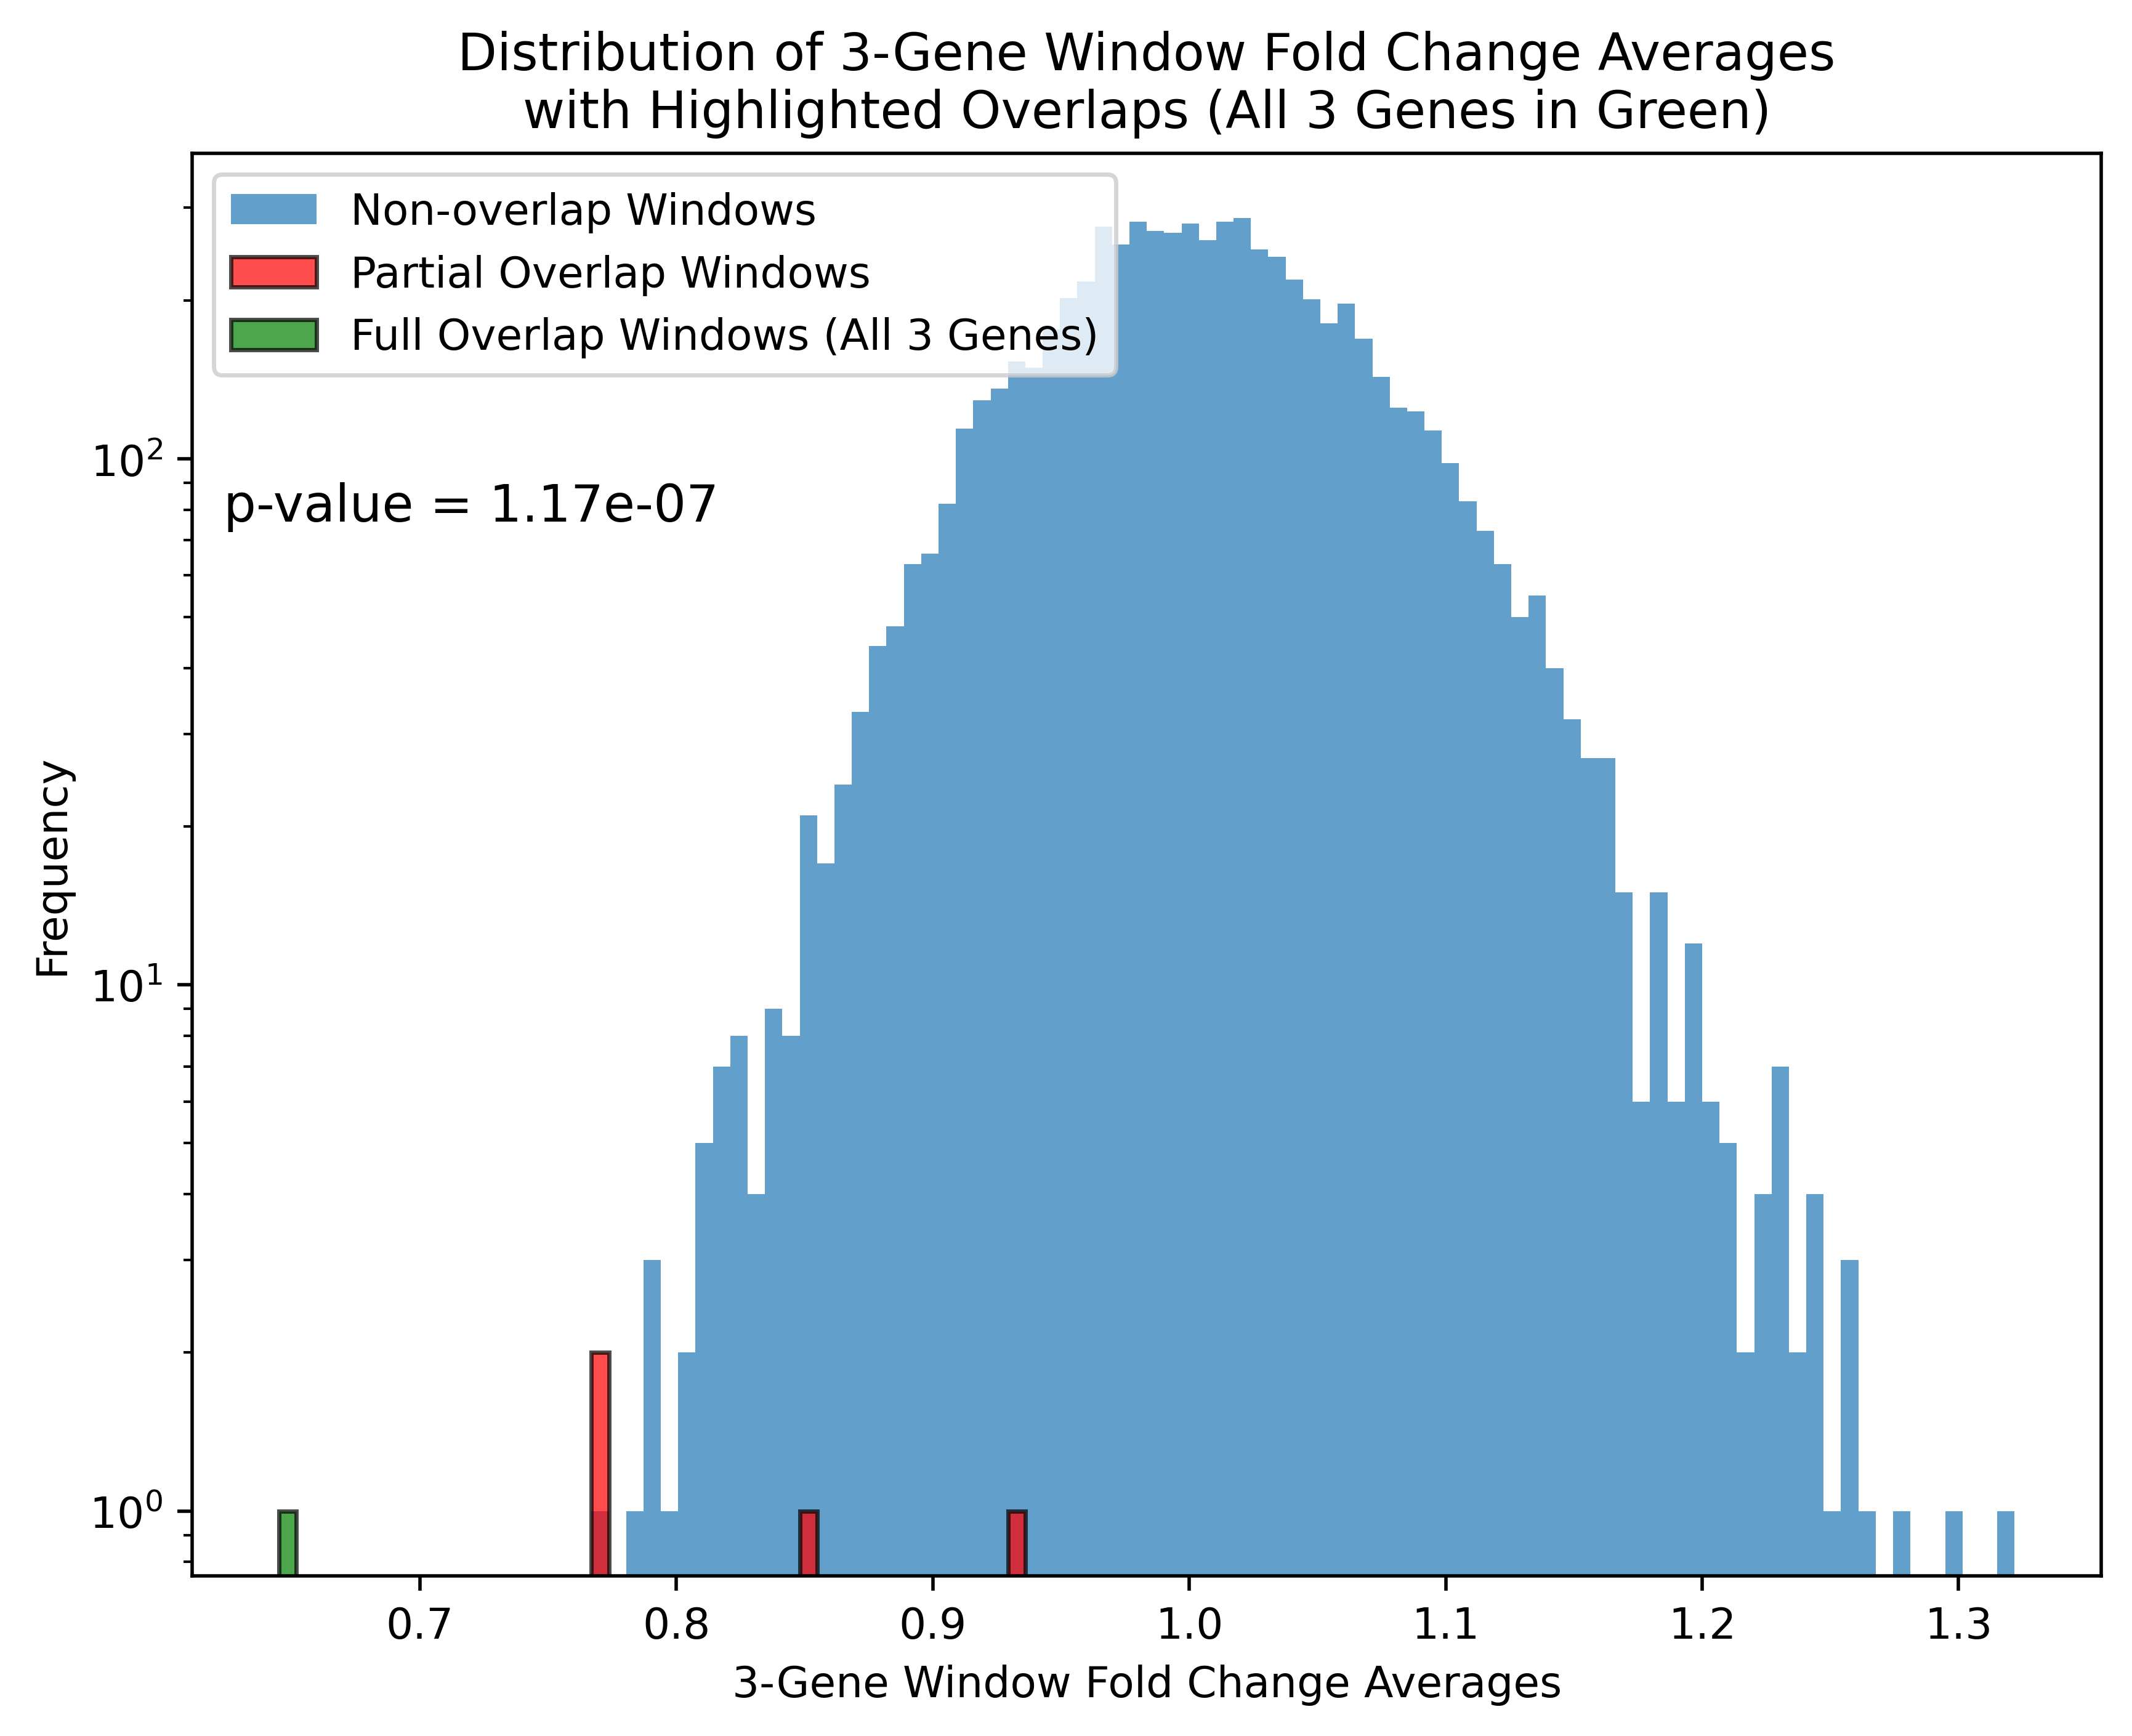

In [90]:
df_genome = pd.read_csv('./output/gene_pvalues_genome.csv')
df_genome = df_genome.rename(columns={'Unnamed: 0': 'gene'})
df_genome = df_genome.sort_values(['chromosome','start'])

# Prepare lists to store data for the histogram and track window positions
rolling_fold_changes = []
window_overlaps = []
full_overlap_windows = []
outlier_windows = []  # To store indices of outlier windows
target_range_chrom = "chr15"
target_range_start = 50426416  # Start of the range
target_range_end = 50873610    # End of the range

# Group by chromosome and calculate rolling averages for each chromosome separately
window_size = 3

for chrom, chrom_data in df_genome.groupby('chromosome'):
    fold_changes = chrom_data['Fold-change'].values
    
    starts = chrom_data['start'].values
    ends = chrom_data['end'].values
    midpoints = (starts+ends)/2#chrom_data['midpoint'].values
    
    # Compute the sliding window average of fold changes and classify windows
    for i in range(len(fold_changes) - window_size + 1):
        window_fc = fold_changes[i:i + window_size].mean()  # Compute rolling average of fold changes
        
        # Extract start and end positions for the current window
        window_starts = starts[i:i + window_size]
        window_ends = ends[i:i + window_size]

        # Only check for overlap if the chromosome is the target one
        if chrom == target_range_chrom:
            # Count how many genes in the window overlap with the target range
            overlap_count = sum((window_starts <= target_range_end) & (window_ends >= target_range_start))

            # Full overlap if all 3 genes in the window overlap
            if overlap_count == 3:
                full_overlap_windows.append(True)
                window_overlaps.append(False)
            # Partial overlap if 1 or 2 genes in the window overlap
            elif 0 < overlap_count < 3:
                window_overlaps.append(True)
                full_overlap_windows.append(False)
            else:
                window_overlaps.append(False)
                full_overlap_windows.append(False)
        else:
            # For non-target chromosomes, do not consider any overlaps
            window_overlaps.append(False)
            full_overlap_windows.append(False)

        # Append fold-change to the list for both target and non-target chromosomes
        rolling_fold_changes.append(window_fc)

        # Check for outliers (rolling mean < 0.7 or > 1.3)
        if window_fc < 0.7 or window_fc > 1.3:
            outlier_windows.append((chrom, i))  # Store chromosome and index of outlier window

# Create bins for a common histogram
bins = np.histogram_bin_edges(rolling_fold_changes, bins=100)  # Create common bins

# Plot the distribution of the sliding window averages with shared bins
plt.figure(figsize=(8, 6))

# Separate the data into categories
non_overlap_values = [rolling_fold_changes[i] for i in range(len(rolling_fold_changes)) if not window_overlaps[i] and not full_overlap_windows[i]]
partial_overlap_values = [rolling_fold_changes[i] for i in range(len(rolling_fold_changes)) if window_overlaps[i]]
full_overlap_values = [rolling_fold_changes[i] for i in range(len(rolling_fold_changes)) if full_overlap_windows[i]]

# Plot the histograms using the common bins
plt.hist(non_overlap_values, bins=bins, alpha=0.7,  label='Non-overlap Windows')
plt.hist(partial_overlap_values, bins=bins, alpha=0.7, color='red',edgecolor='black',  label='Partial Overlap Windows')
plt.hist(full_overlap_values, bins=bins, alpha=0.7, color='green',edgecolor='black', label='Full Overlap Windows (All 3 Genes)')

# Add labels and a legend
plt.legend()
plt.xlabel('3-Gene Window Fold Change Averages')
plt.ylabel('Frequency')
plt.title('Distribution of 3-Gene Window Fold Change Averages\nwith Highlighted Overlaps (All 3 Genes in Green)')
plt.grid(False)
plt.yscale('log')


non_overlap_values = np.array(non_overlap_values)

# The single value from full_overlap_values
print(full_overlap_values)
single_value = np.array(full_overlap_values)[0]

# Calculate the mean and standard deviation of the original distribution
original_mean = np.mean(non_overlap_values)
original_std = np.std(non_overlap_values)

# Calculate the Z-score for the single value
z_score = (single_value - original_mean) / original_std

p_value = 2 * (1 - norm.cdf(abs(z_score)))
plt.text(0.72, max(plt.gca().get_ylim()) * 0.2, f'p-value = {p_value:.2e}', fontsize=12, ha='center', color='black')
plt.savefig("./output/foldchange_histogram.png", dpi=500)